# Question 3

## 1. Audio Data

In [ ]:
!pip install sounddevice wavio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 156.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.2/21.2 MB 4.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import sounddevice as sd
import os
from scipy.io.wavfile import write


def record(duration=2, sample_rate=44100):
    print("Recording started...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='int16')
    sd.wait()
    print("finished")
    return audio


def record_wake_word(sample_rate=44100, num=100):
    wake_word_dir = 'data/wake_word'
    if not os.path.exists(wake_word_dir):
        os.makedirs(wake_word_dir)

    for i in range(num):
        print(f"recording wake word #{i+1}")
        audio = record()
        file_path = os.path.join(wake_word_dir, f'wake_word_{i+1}.wav')
        write(file_path, sample_rate, audio)
        print(f"audio saved.")
        print('=+=+=+=+=')


def record_background(sample_rate=44100, num=100):
    background_sound_dir = 'data/background'
    if not os.path.exists(background_sound_dir):
        os.makedirs(background_sound_dir)

    for i in range(num):
        print(f"recording background #{i+1}")
        audio = record()
        file_path = os.path.join(background_sound_dir, f'background_sound_{i+1}.wav')
        write(file_path, sample_rate, audio)
        print(f"audio saved.")


record_wake_word()
record_background()

recording wake word #1
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #2
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #3
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #4
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #5
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #6
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #7
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #8
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #9
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #10
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #11
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #12
Recording started...
finished
audio saved.
=+=+=+=+=
recording wake word #13
Recording started...
finished
audio saved.
=+=+=+=+=
recordin

## 2. Preprocessing and Feature Extraction

In [21]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical

In [2]:
wake_word_path = 'data/wake_word'
background_path = 'data/background'

### functions for augmentation

In [5]:
# augmentation
def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_level * noise
    # Normalization
    augmented_audio = augmented_audio / np.max(np.abs(augmented_audio))
    return augmented_audio

def time_shift(audio, sr=44100, shift_max=0.2):
    shift = np.random.randint(sr * shift_max)
    direction = np.random.randint(0, 2)
    if direction == 1:
        shift = -shift
    augmented_audio = np.roll(audio, shift)
    if shift > 0:
        augmented_audio[:shift] = 0
    else:
        augmented_audio[shift:] = 0
    return augmented_audio


def pitch_shift(audio, sr=44100, n_steps=4):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def augment(audio):

    augmented_audios = [audio]
    augmented_audios.append(add_noise(audio))
    augmented_audios.append(time_shift(audio))
    augmented_audios.append(pitch_shift(audio))

    return augmented_audios

In [7]:
def load_audio(file_path, sr=44100):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

def extract_mfcc_features(audio, sr=44100, n_mfcc=13, n_fft=2048, hop_length=512, fixed_length=44):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs = librosa.util.fix_length(mfccs, size=fixed_length, axis=1)
    return mfccs

def process_and_extract_features(audio, sr=44100, n_mfcc=13, fixed_length=44):
    normalized_audio = normalize_audio(audio)
    mfcc_features = extract_mfcc_features(normalized_audio, sr, n_mfcc, fixed_length=fixed_length)
    return mfcc_features


def load_dataset(wake_word_path, background_path, fixed_length=44):
    wake_word_files = [os.path.join(wake_word_path, f) for f in os.listdir(wake_word_path) if f.endswith('.wav')]
    background_files = [os.path.join(background_path, f) for f in os.listdir(background_path) if f.endswith('.wav')]

    X = []
    y = []

    for file_path in wake_word_files:
        aud = load_audio(file_path, sr=44100)
        audios = augment(aud)
        for audio in audios:
            mfcc_features = process_and_extract_features(audio, fixed_length=fixed_length)
            X.append(mfcc_features)
            y.append(1)

    for file_path in background_files:
        aud = load_audio(file_path, sr=44100)
        audios = augment(aud)
        for audio in audios:
            mfcc_features = process_and_extract_features(audio, fixed_length=fixed_length)
            X.append(mfcc_features)
            y.append(0)

    X = np.array(X)
    y = np.array(y)

    X = X[..., np.newaxis]

    return X, y

fixed_length = 100
X, y = load_dataset(wake_word_path, background_path, fixed_length=fixed_length)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test = to_categorical(y_test, num_classes=2)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)


print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


Training data shape: (576, 13, 100, 1)
Validation data shape: (144, 13, 100, 1)
Test data shape: (80, 13, 100, 1)


## 3. Neural Network

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = X_train.shape[1:]
num_classes = 2

model = create_cnn_model(input_shape, num_classes)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 11, 98, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 49, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 47, 128)        73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 23, 128)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2944)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [13]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
18/18 [==============================] - 3s 102ms/step - loss: 7.4037 - accuracy: 0.5052 - val_loss: 0.6205 - val_accuracy: 0.5972
Epoch 2/30
18/18 [==============================] - 2s 86ms/step - loss: 0.5214 - accuracy: 0.7691 - val_loss: 0.3768 - val_accuracy: 0.8472
Epoch 3/30
18/18 [==============================] - 1s 83ms/step - loss: 0.3694 - accuracy: 0.8559 - val_loss: 0.2827 - val_accuracy: 0.8681
Epoch 4/30
18/18 [==============================] - 2s 86ms/step - loss: 0.3211 - accuracy: 0.8681 - val_loss: 0.2922 - val_accuracy: 0.8681
Epoch 5/30
18/18 [==============================] - 2s 135ms/step - loss: 0.2642 - accuracy: 0.9115 - val_loss: 0.2652 - val_accuracy: 0.8819
Epoch 6/30
18/18 [==============================] - 3s 143ms/step - loss: 0.2222 - accuracy: 0.9253 - val_loss: 0.2160 - val_accuracy: 0.9097
Epoch 7/30
18/18 [==============================] - 2s 123ms/step - loss: 0.1932 - accuracy: 0.9288 - val_loss: 0.1831 - val_accuracy: 0.9444
Epoch 8/3

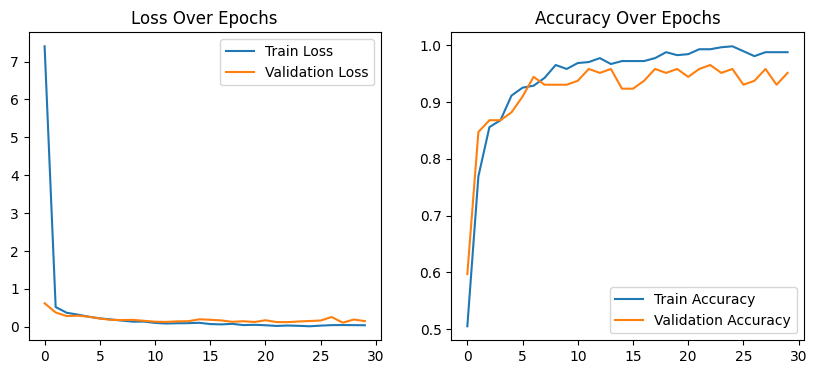

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3/3 [==============================] - 0s 17ms/step - loss: 0.2198 - accuracy: 0.9125
Test Loss: 0.21984639763832092
Test Accuracy: 0.9125000238418579


3/3 [==============================] - 0s 16ms/step


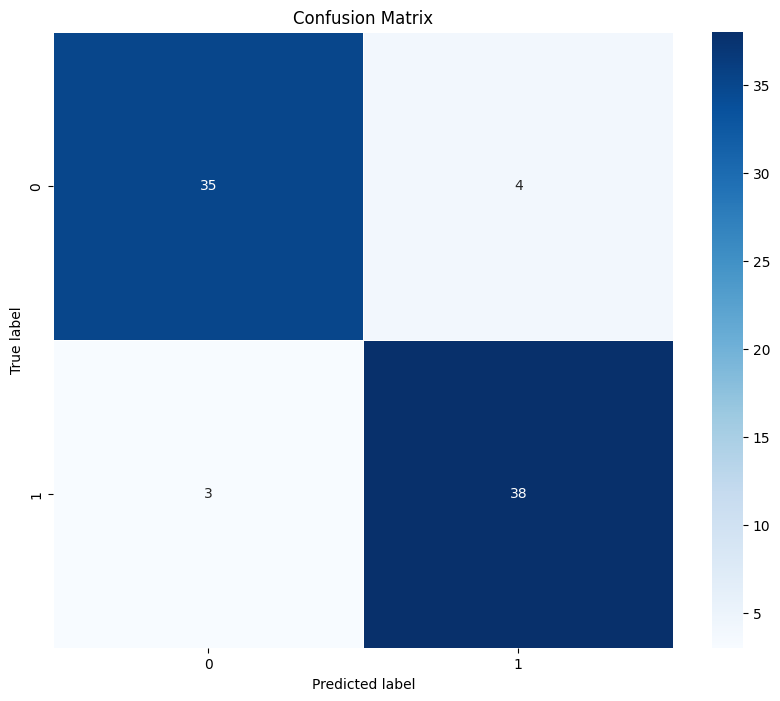

In [22]:
Y_pred = model.predict(X_test)

Y_pred_classes = np.argmax(Y_pred, axis=1)

Y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', linewidths=.5, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
